In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import sys
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# load data

df = pd.read_csv("MERGED_SDOH_PLUS_UTIL_20_RenamedColumns.csv")
df.head()

,CountyFIPS,State,County,Region,Total_population_poverty,Pct_disabled,Pct_age_65plus,Pct_single_parent,Median_hh_income,Pct_hh_65_alone,...,Pct_renter_cost_50pct_plus,Pct_renter_occupied,Pct_homes_no_vehicle,Pct_public_transit,Land_area_sqmi,Population_density,Distance_to_ED,Distance_to_medsurge_icu,Bed_util_ratio,Is_Metro_Micro
0,1017,Alabama,Chambers County,South,32875.0,18.777777,20.333333,42.111111,42440.0,11.777777,...,12.000000,31.666666,7.222222,0.333333,66.333333,273.333333,6.333333,7.555555,0.449367,True
1,1027,Alabama,Clay County,South,13002.0,18.500000,21.000000,27.250000,43213.0,12.250000,...,5.750000,22.250000,5.500000,0.000000,151.000000,24.500000,6.750000,6.750000,0.380401,False
2,1065,Alabama,Hale County,South,14512.0,25.142857,19.428571,42.714285,33652.0,18.000000,...,24.142857,22.428571,8.857142,0.142857,92.000000,68.714285,7.857142,20.714285,0.198380,True
3,1091,Alabama,Marengo County,South,18882.0,25.000000,19.250000,44.500000,36130.0,15.875000,...,23.125000,29.625000,9.875000,0.000000,122.000000,90.500000,9.500000,13.875000,0.374947,False
4,2013,Alaska,Aleutians East Borough,West,3379.0,11.000000,11.000000,55.000000,75833.0,11.000000,...,21.000000,39.000000,22.000000,0.000000,6985.000000,0.000000,361.000000,487.000000,NaN,NaN


In [5]:
# split ratio calc

def calcSplitRatio(df, p = 22):
    if p is None:
        p = df.shape[1] - 1
        
    ## Calculate ideal number for testing set
    test_N = (1 / np.sqrt(p)) * len(df)

    ## Calculate testing proportion
    test_prop = round(test_N / len(df), 2)

    ## Calculate training proportion
    train_prop = 1 - test_prop

    ## Print the results
    print(f"The ideal split ration is {train_prop}:{test_prop} training:testing")

    ## Return the size of the training set proportion
    return train_prop

calcSplitRatio(df, p = 22)

The ideal split ration is 0.79:0.21 training:testing


0.79

In [7]:
# encode categorical variables
# region

# OneHotEncode
encoder = OneHotEncoder(sparse = False)
region_encoded = encoder.fit_transform(df[['Region']])

# Create new DataFrame with encoded columns
region_encoded_df = pd.DataFrame(region_encoded, 
                                 columns = encoder.get_feature_names_out(['Region']))

# Combine back with original data 
df = pd.concat([df.drop(columns = 'Region'), region_encoded_df], axis = 1)


In [9]:
df.head()

,CountyFIPS,State,County,Total_population_poverty,Pct_disabled,Pct_age_65plus,Pct_single_parent,Median_hh_income,Pct_hh_65_alone,Pct_mobile_homes,...,Population_density,Distance_to_ED,Distance_to_medsurge_icu,Bed_util_ratio,Is_Metro_Micro,Region_Midwest,Region_Northeast,Region_South,Region_West,Region_nan
0,1017,Alabama,Chambers County,32875.0,18.777777,20.333333,42.111111,42440.0,11.777777,13.555555,...,273.333333,6.333333,7.555555,0.449367,True,0.0,0.0,1.0,0.0,0.0
1,1027,Alabama,Clay County,13002.0,18.500000,21.000000,27.250000,43213.0,12.250000,24.000000,...,24.500000,6.750000,6.750000,0.380401,False,0.0,0.0,1.0,0.0,0.0
2,1065,Alabama,Hale County,14512.0,25.142857,19.428571,42.714285,33652.0,18.000000,42.285714,...,68.714285,7.857142,20.714285,0.198380,True,0.0,0.0,1.0,0.0,0.0
3,1091,Alabama,Marengo County,18882.0,25.000000,19.250000,44.500000,36130.0,15.875000,27.250000,...,90.500000,9.500000,13.875000,0.374947,False,0.0,0.0,1.0,0.0,0.0
4,2013,Alaska,Aleutians East Borough,3379.0,11.000000,11.000000,55.000000,75833.0,11.000000,6.000000,...,0.000000,361.000000,487.000000,NaN,NaN,0.0,0.0,0.0,1.0,0.0


In [11]:
# state

df['state_count'] = df['State'].map(df['State'].value_counts())
df = df.drop(columns = ['State', 'County'])
df.head()

,CountyFIPS,Total_population_poverty,Pct_disabled,Pct_age_65plus,Pct_single_parent,Median_hh_income,Pct_hh_65_alone,Pct_mobile_homes,Pct_owner_cost_30plus,Pct_renter_cost_30pct_plus,...,Distance_to_ED,Distance_to_medsurge_icu,Bed_util_ratio,Is_Metro_Micro,Region_Midwest,Region_Northeast,Region_South,Region_West,Region_nan,state_count
0,1017,32875.0,18.777777,20.333333,42.111111,42440.0,11.777777,13.555555,17.777777,31.666666,...,6.333333,7.555555,0.449367,True,0.0,0.0,1.0,0.0,0.0,67
1,1027,13002.0,18.500000,21.000000,27.250000,43213.0,12.250000,24.000000,14.250000,29.500000,...,6.750000,6.750000,0.380401,False,0.0,0.0,1.0,0.0,0.0,67
2,1065,14512.0,25.142857,19.428571,42.714285,33652.0,18.000000,42.285714,23.714285,58.714285,...,7.857142,20.714285,0.198380,True,0.0,0.0,1.0,0.0,0.0,67
3,1091,18882.0,25.000000,19.250000,44.500000,36130.0,15.875000,27.250000,22.875000,55.125000,...,9.500000,13.875000,0.374947,False,0.0,0.0,1.0,0.0,0.0,67
4,2013,3379.0,11.000000,11.000000,55.000000,75833.0,11.000000,6.000000,11.000000,33.000000,...,361.000000,487.000000,NaN,NaN,0.0,0.0,0.0,1.0,0.0,30


In [13]:
# metro micro
# OneHotEncode
encoder_mm = OneHotEncoder(sparse = False)
mm_encoded = encoder_mm.fit_transform(df[['Is_Metro_Micro']])

# Create new DataFrame with encoded columns
mm_encoded_df = pd.DataFrame(mm_encoded, 
                             columns = encoder_mm.get_feature_names_out(['Is_Metro_Micro']))

df = pd.concat([df.drop(columns = 'Is_Metro_Micro'), mm_encoded_df], axis=1)
df.head()

,CountyFIPS,Total_population_poverty,Pct_disabled,Pct_age_65plus,Pct_single_parent,Median_hh_income,Pct_hh_65_alone,Pct_mobile_homes,Pct_owner_cost_30plus,Pct_renter_cost_30pct_plus,...,Bed_util_ratio,Region_Midwest,Region_Northeast,Region_South,Region_West,Region_nan,state_count,Is_Metro_Micro_False,Is_Metro_Micro_True,Is_Metro_Micro_nan
0,1017,32875.0,18.777777,20.333333,42.111111,42440.0,11.777777,13.555555,17.777777,31.666666,...,0.449367,0.0,0.0,1.0,0.0,0.0,67,0.0,1.0,0.0
1,1027,13002.0,18.500000,21.000000,27.250000,43213.0,12.250000,24.000000,14.250000,29.500000,...,0.380401,0.0,0.0,1.0,0.0,0.0,67,1.0,0.0,0.0
2,1065,14512.0,25.142857,19.428571,42.714285,33652.0,18.000000,42.285714,23.714285,58.714285,...,0.198380,0.0,0.0,1.0,0.0,0.0,67,0.0,1.0,0.0
3,1091,18882.0,25.000000,19.250000,44.500000,36130.0,15.875000,27.250000,22.875000,55.125000,...,0.374947,0.0,0.0,1.0,0.0,0.0,67,1.0,0.0,0.0
4,2013,3379.0,11.000000,11.000000,55.000000,75833.0,11.000000,6.000000,11.000000,33.000000,...,NaN,0.0,0.0,0.0,1.0,0.0,30,0.0,0.0,1.0


In [15]:
df.isnull().sum()


CountyFIPS                      0
Total_population_poverty        5
Pct_disabled                    5
Pct_age_65plus                  5
Pct_single_parent               5
Median_hh_income                5
Pct_hh_65_alone                 5
Pct_mobile_homes                5
Pct_owner_cost_30plus           5
Pct_renter_cost_30pct_plus      5
Pct_renter_cost_50pct_plus      5
Pct_renter_occupied             5
Pct_homes_no_vehicle            5
Pct_public_transit              5
Land_area_sqmi                  5
Population_density              5
Distance_to_ED                  5
Distance_to_medsurge_icu        5
Bed_util_ratio                818
Region_Midwest                  0
Region_Northeast                0
Region_South                    0
Region_West                     0
Region_nan                      0
state_count                     0
Is_Metro_Micro_False            0
Is_Metro_Micro_True             0
Is_Metro_Micro_nan              0
dtype: int64

In [17]:
cols_with_5_nulls = [
    'Total_population_poverty', 'Pct_disabled', 'Pct_age_65plus', 
    'Pct_single_parent', 'Median_hh_income', 'Pct_hh_65_alone', 
    'Pct_mobile_homes', 'Pct_owner_cost_30plus', 'Pct_renter_cost_30pct_plus', 
    'Pct_renter_cost_50pct_plus', 'Pct_renter_occupied', 'Pct_homes_no_vehicle', 
    'Pct_public_transit', 'Land_area_sqmi', 'Population_density', 
    'Distance_to_ED', 'Distance_to_medsurge_icu'
]

# Drop rows where any of these are null
df = df.dropna(subset = cols_with_5_nulls)
df.isnull().sum()

CountyFIPS                      0
Total_population_poverty        0
Pct_disabled                    0
Pct_age_65plus                  0
Pct_single_parent               0
Median_hh_income                0
Pct_hh_65_alone                 0
Pct_mobile_homes                0
Pct_owner_cost_30plus           0
Pct_renter_cost_30pct_plus      0
Pct_renter_cost_50pct_plus      0
Pct_renter_occupied             0
Pct_homes_no_vehicle            0
Pct_public_transit              0
Land_area_sqmi                  0
Population_density              0
Distance_to_ED                  0
Distance_to_medsurge_icu        0
Bed_util_ratio                818
Region_Midwest                  0
Region_Northeast                0
Region_South                    0
Region_West                     0
Region_nan                      0
state_count                     0
Is_Metro_Micro_False            0
Is_Metro_Micro_True             0
Is_Metro_Micro_nan              0
dtype: int64

In [19]:
# random forest for impute

# Separate rows with and without Bed_util_ratio
known = df[df['Bed_util_ratio'].notnull()]
unknown = df[df['Bed_util_ratio'].isnull()]

# Features to train on (excluding target and identifiers)
features = [col for col in df.columns if col not in ['Bed_util_ratio']]

# Train RF model
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(known[features], known['Bed_util_ratio'])

# Predict missing values
predictions = rf.predict(unknown[features])

# Fill in predictions
df.loc[unknown.index, 'Bed_util_ratio'] = predictions

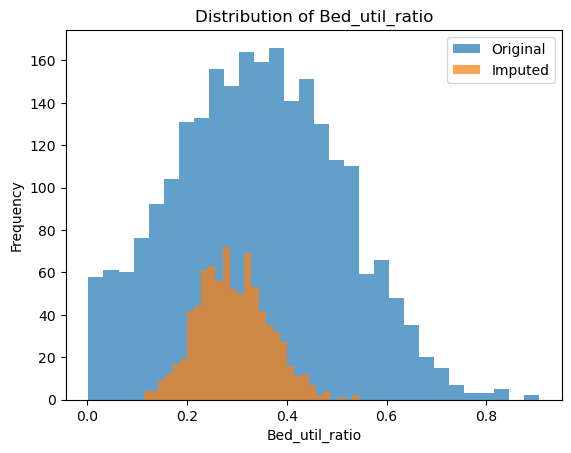

In [23]:
import matplotlib.pyplot as plt
# distribution of before and after imputation

# Before imputation (from earlier stored variable)
plt.hist(known['Bed_util_ratio'], bins = 30, alpha = 0.7, label = 'Original')

# After imputation
plt.hist(df.loc[unknown.index, 'Bed_util_ratio'], bins = 30, alpha = 0.7, label = 'Imputed')
plt.legend()
plt.title('Distribution of Bed_util_ratio')
plt.xlabel('Bed_util_ratio')
plt.ylabel('Frequency')
plt.show()


In [25]:
df.isnull().sum()

CountyFIPS                    0
Total_population_poverty      0
Pct_disabled                  0
Pct_age_65plus                0
Pct_single_parent             0
Median_hh_income              0
Pct_hh_65_alone               0
Pct_mobile_homes              0
Pct_owner_cost_30plus         0
Pct_renter_cost_30pct_plus    0
Pct_renter_cost_50pct_plus    0
Pct_renter_occupied           0
Pct_homes_no_vehicle          0
Pct_public_transit            0
Land_area_sqmi                0
Population_density            0
Distance_to_ED                0
Distance_to_medsurge_icu      0
Bed_util_ratio                0
Region_Midwest                0
Region_Northeast              0
Region_South                  0
Region_West                   0
Region_nan                    0
state_count                   0
Is_Metro_Micro_False          0
Is_Metro_Micro_True           0
Is_Metro_Micro_nan            0
dtype: int64

In [27]:
df.loc[unknown.index, ['Bed_util_ratio']]


,Bed_util_ratio
4,0.340976
5,0.360214
6,0.342179
7,0.348986
13,0.304982
...,...
3226,0.350359
3227,0.311096
3228,0.352821
3229,0.389204


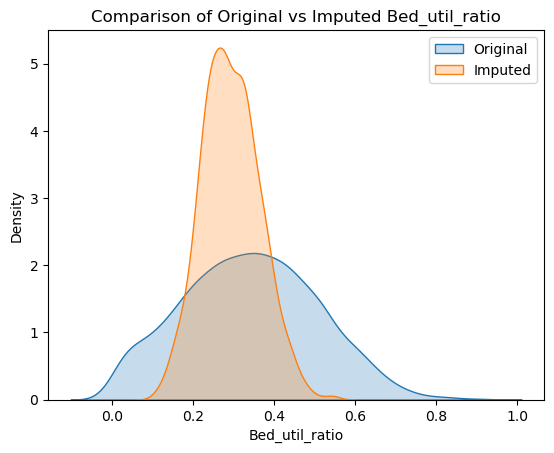

In [29]:
# Distribution plots
sns.kdeplot(known['Bed_util_ratio'], label = 'Original', fill = True)
sns.kdeplot(df.loc[unknown.index, 'Bed_util_ratio'], label = 'Imputed', fill = True)
plt.title('Comparison of Original vs Imputed Bed_util_ratio')
plt.legend()
plt.show()



In [31]:
# Drop 10% of known values artificially
temp_known = known.copy()
sample = temp_known.sample(frac=0.1, random_state=42)
temp_known.loc[sample.index, 'Bed_util_ratio'] = np.nan

# Split
X_train = temp_known.dropna().drop(columns=['Bed_util_ratio'])
y_train = temp_known.dropna()['Bed_util_ratio']
X_test = sample.drop(columns = ['Bed_util_ratio'])

# Fit model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Predict missing
y_pred = rf.predict(X_test)

# Compare
mse = mean_squared_error(sample['Bed_util_ratio'], y_pred)
print(f"Imputation RMSE: {np.sqrt(mse):.4f}")


Imputation RMSE: 0.1261


# Results

The RMSE score (0.1261) is good, meaning the RF model was able to predict the missing vlaues with relatively low error. It's 12% average prediction error, reasonable. 

BUT, when it comes to the distribution check, gave bad results. A good result would show the 2 curves with similar shape and scale. This is a red flag, since it suggests the model is overconfident or underfitting the actual complexity of the missing data. 

## I recommend not to use RF for imputation. 

In [36]:
df_rea = pd.read_csv("df_encoded.xlsx - data.csv")
df_rea.head()

,CountyFIPS,State,County,Total_population_poverty,Pct_disabled,Pct_age_65plus,Pct_single_parent,Median_hh_income,Pct_hh_65_alone,Pct_mobile_homes,...,Bed_util_ratio,Is_Metro_Micro,Region_Midwest,Region_Northeast,Region_South,Region_West,State_Count,State_target,County_Count,County_target
0,1017,Alabama,Chambers County,32875,18.777777,20.333333,42.111111,42440,11.777777,13.555555,...,0.449367,1.0,0,0,1,0,67,0.375052,2,0.449367
1,1027,Alabama,Clay County,13002,18.500000,21.000000,27.250000,43213,12.250000,24.000000,...,0.380401,0.0,0,0,1,0,67,0.375052,18,0.380401
2,1065,Alabama,Hale County,14512,25.142857,19.428571,42.714285,33652,18.000000,42.285714,...,0.198380,1.0,0,0,1,0,67,0.375052,2,0.198380
3,1091,Alabama,Marengo County,18882,25.000000,19.250000,44.500000,36130,15.875000,27.250000,...,0.374947,0.0,0,0,1,0,67,0.375052,1,0.374947
4,2013,Alaska,Aleutians East Borough,3379,11.000000,11.000000,55.000000,75833,11.000000,6.000000,...,NaN,NaN,0,0,0,1,30,0.332938,1,NaN


In [38]:
df_rea.isnull().sum()

CountyFIPS                      0
State                           0
County                          0
Total_population_poverty        0
Pct_disabled                    0
Pct_age_65plus                  0
Pct_single_parent               0
Median_hh_income                0
Pct_hh_65_alone                 0
Pct_mobile_homes                0
Pct_owner_cost_30plus           0
Pct_renter_cost_30pct_plus      0
Pct_renter_cost_50pct_plus      0
Pct_renter_occupied             0
Pct_homes_no_vehicle            0
Pct_public_transit              0
Land_area_sqmi                  0
Population_density              0
Distance_to_ED                  0
Distance_to_medsurge_icu        0
Bed_util_ratio                751
Is_Metro_Micro                751
Region_Midwest                  0
Region_Northeast                0
Region_South                    0
Region_West                     0
State_Count                     0
State_target                    0
County_Count                    0
County_target 